In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from bs4 import BeautifulSoup
import wordcloud
import spacy
import requests

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

import time

## URLs

### Note that you have to use your url of interest and may adopt your artists of interest instead of mine

In [2]:
#System of a Down:
SOAD_original_url = 'https://your url for songtexts'
SOAD_original_html = requests.get(SOAD_original_url).text
SOAD_soup = BeautifulSoup(SOAD_original_html)

#Emil Bulls:
EB_original_url = 'https://your url for songtexts'
EB_original_html = requests.get(EB_original_url).text
EB_soup = BeautifulSoup(EB_original_html)

#blink182:
b182_original_url = 'https://your url for songtexts'
b182_original_html = requests.get(b182_original_url).text
b182_soup = BeautifulSoup(b182_original_html)

## *def allSongsPerBand: get lyrics from https://www... , add url (value) and title (key) to a dictionary

In [3]:
url_dict = {}

#extracting all band-specific lyrics from https://www...
#and add url and title to url_dict
def allSongsPerBand(soup, band):
    for song in soup.find_all(class_='nested'):   #SOAD_soup
        song_href = song.get('href')
        if '/album/' not in song_href:
            song_href = song_href.replace('../','https://www.../')
            #extract song name (to be later used as key in dict)
            last_slash = song_href.rfind("/")
            last_minus = song_href.rfind("-")
            titlePartly = song_href[last_slash+1:last_minus].replace('-','_')
            title = band + '_' + titlePartly
            
            url_dict.update({title:song_href})     

## Call *def allSongsPerBand

In [4]:
allSongsPerBand(SOAD_soup, 'SOAD')
allSongsPerBand(EB_soup, 'EB')
allSongsPerBand(b182_soup, 'b182')
#print(url_dict)

### Get lyrics from URL

In [5]:
s = requests.Session()
#you need to set your 'user agent e.g. your browser' as dictionary value
headers = {'User-Agent': 'user agent e.g. your browser'}


#song: key of dict, url: value of dict
def get_html(song,url):
    response = s.get(url, headers = headers)
    
    #convert html text to BeautifulSoup text:
    html = response.text
    soup = BeautifulSoup(html, 'html.parser')
    lyrics = soup.find_all('div', attrs={'id': 'lyrics'})[0].text
        
    #save file as csv (if you want it for further later processing):
    f=open(f'rawData/{song}.csv', 'w')
    #check if songtext exists 
    if 'Leider kein Songtext vorhanden' not in lyrics:
        f.write(lyrics)
    else:
        f.write('')
    f.close()

    
    time.sleep(2)   #wait 2 seconds to receive new html file
    
    
#call function 'get_html' for every song /  url
for song,url in url_dict.items():
    get_html(song,url)


## *def loadFile: Open saved lyrics and clean data 

In [6]:
def loadFile(filename):
    f=open(filename, 'r')
    contents = f.read()
    contents = contents.replace('\n',' ')
    contents = contents.replace('<!--/*--><![CDATA[/*><!--*/ ADNPM.cmd.push(function(){ADNPM.loadAd(6670665)}); /*-->]]>*/' ,' ')
    return contents

## *def wordCloud: Draw a word cloud and save it as png

In [15]:
def wordCloud(lyrics,song):
    #exemplarily shown in this notebook for only one song (--> if statement)
    if 'your song' in song:   #replace 'your song' with your song of interest
        mask = np.zeros((500, 500), np.uint8)
        mask[0:200,0:200] = 255  # masked out area

        cloud = wordcloud.WordCloud(background_color="white",
                        max_words=60,
                        mask=mask,
                        collocations=False,  # calculates frequencies
                        contour_color='steelblue').generate(lyrics)
                        # stop words are removed!

        plt.figure(figsize = (10,10))
        plt.imshow(cloud, interpolation='bilinear')
        plt.savefig(f'picsnplots/{song}.png')
        plt.show()

## *def tokenize: Tokenization and 'Simplyfication' of lyrics using Spacy

In [16]:
model = spacy.load('en_core_web_md')

In [17]:
def tokenize(lyrics):
    tokenised_lyrics = model(lyrics)
    clean_lyrics = ''
    for token in tokenised_lyrics:
        #delete stop words
        #return lemmatized words
        if not token.is_stop:
            clean_lyrics += token.lemma_ + ' '           
    return clean_lyrics

## Call *def wordCloud and *def tokenize

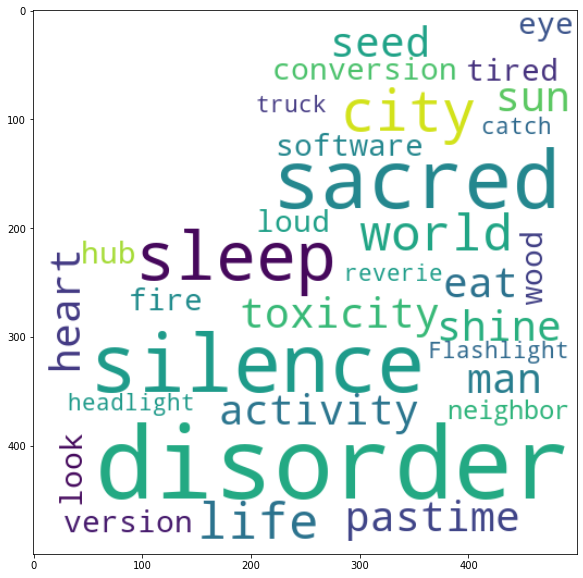

In [18]:
for song in url_dict.keys():
    try:
        rawText = loadFile(f'rawData/{song}.csv')
        tok_RawText = tokenize(rawText)
        #save and show wordCloud pictures:
        wordCloud(tok_RawText, song)
    except:
        pass

## Merge different artist specific lyrics as single Strings

In [19]:
SOAD = ''
EB = ''
b182 = ''

for song in url_dict.keys():
    rawText = loadFile(f'rawData/{song}.csv')
    tok_RawText = tokenize(rawText)
    
    if "SOAD_" in song:
        SOAD += tok_RawText + ' '
    elif "EB_" in song:
        EB += tok_RawText + ' '
    elif "b182_" in song:        
        b182 += tok_RawText + ' '

## Vectorization (including Transformation)

In [20]:
#load lyrics into a corpus
corpus = [SOAD, EB, b182]

#vectorize lyrics
cv = CountVectorizer(stop_words='english')

#fit corpus with CountVectorizer()
cv.fit(corpus)

#transform fitted corpus
out = cv.transform(corpus)

#display transformed corpus as normalized vector
out.todense()
#print(out)

matrix([[2, 0, 0, ..., 3, 0, 0],
        [0, 1, 0, ..., 0, 1, 1],
        [0, 0, 1, ..., 1, 0, 0]], dtype=int64)

In [21]:
#create sparse Matrix
df = pd.DataFrame(out.todense(), columns = cv.get_feature_names())
df

,00,10050,11,1985,21,23,2x,30,3x,5x,...,yeah,year,yell,yellow,yes,yesterday,young,youth,zamzoe,zone
0,2,0,0,1,0,0,0,0,0,0,...,10,6,0,1,0,0,6,3,0,0
1,0,1,0,0,0,1,3,0,3,1,...,18,1,0,0,5,1,2,0,1,1
2,0,0,1,0,3,0,0,1,0,0,...,10,8,1,0,1,3,3,1,0,0


In [22]:
#Term frequency normalization (Tf-Idf)
tf = TfidfTransformer()
transformed = tf.fit_transform(out)
#transformed

tdf = pd.DataFrame(transformed.todense(), columns = cv.get_feature_names())
tdf.round(2)
# cv.get_feature_names()

,00,10050,11,1985,21,23,2x,30,3x,5x,...,yeah,year,yell,yellow,yes,yesterday,young,youth,zamzoe,zone
0,0.01,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,...,0.02,0.01,0.0,0.0,0.00,0.00,0.01,0.01,0.00,0.00
1,0.00,0.01,0.0,0.0,0.00,0.01,0.02,0.0,0.02,0.01,...,0.06,0.00,0.0,0.0,0.02,0.00,0.01,0.00,0.01,0.01
2,0.00,0.00,0.0,0.0,0.01,0.00,0.00,0.0,0.00,0.00,...,0.03,0.02,0.0,0.0,0.00,0.01,0.01,0.00,0.00,0.00


### Naive Bayes

In [23]:
#assign X and y
X = tdf.values
y = ['SOAD'],['EB'],['b182']
y

(['SOAD'], ['EB'], ['b182'])

In [24]:
#Naive Bayes Classifier (multinomial)
m = MultinomialNB(alpha=0.01)   # high alpha: more regularization
m.fit(X, np.ravel(y))
m.score(X, y)

1.0

In [25]:
m.predict_proba(X) # for each song: P(SOAD), P(EB), P(b182)
#note that order of artists changed --> can be displayed using 'm.classes_'

array([[5.19418936e-08, 9.99999802e-01, 1.45830143e-07],
       [9.99999148e-01, 9.18496930e-08, 7.59841357e-07],
       [8.70827358e-06, 6.04438384e-06, 9.99985247e-01]])

In [26]:
m.classes_
#order of artists got rearranged (alphabetical order (ASCII))

array(['EB', 'SOAD', 'b182'], dtype='<U4')

### Prediction for a new song

In [27]:
# EB: Take on me (not included in train data)
song = ["...bla....bla...bla..."] 

counts = cv.transform(song)
tfcounts = tf.transform(counts)
m.predict(tfcounts)

array(['EB'], dtype='<U4')

In [28]:
m.predict_proba(tfcounts).round(5)

array([[0.49932, 0.11986, 0.38082]])

In [29]:
#show calculated probability for every artist in a dataFrame
df = pd.DataFrame(m.predict_proba(tfcounts).round(5).T, index=m.classes_, columns=['Probability'])
df

,Probability
EB,0.49932
SOAD,0.11986
b182,0.38082
